In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('copia.csv', parse_dates= ['date_order'])
data.head()

C:\Users\maure\AppData\Local\Temp\ipykernel_9732\4078187727.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data = pd.read_csv('copia.csv', parse_dates= ['date_order'])


,customer_id,order_id,date_order,spend,category,margin
0,4540910,36965281.0,2023-07-31,51.72,Beauty,18.5400
1,5392962,36733011.0,2023-07-24,185.34,Foodstuff,16.5383
2,2294191,36413968.0,2023-07-15,444.00,Foodstuff,27.3334
3,5566823,36541949.0,2023-07-19,4564.66,Electronics,1116.3800
4,577996,35967178.0,2023-05-07,190.00,Foodstuff,82.9200


In [3]:
data.isnull().sum()

customer_id      0
order_id       996
date_order       0
spend            0
category         0
margin           0
dtype: int64

In [4]:
len(data)

1048575

In [5]:
data = data.sample(500000,random_state=4)
data.head()

,customer_id,order_id,date_order,spend,category,margin
843475,6009636,36920852.0,2023-07-29,370.69,Foodstuff,29.01
999669,5930318,36432697.0,2023-07-15,159.48,Household,34.48
931200,3006077,36345354.0,2023-07-14,190.00,Foodstuff,11.52
792931,4627416,35853194.0,2023-03-07,155.17,Beauty,34.09
403727,6004847,36889860.0,2023-07-28,39.66,School,12.06


In [6]:
len(data)

500000

In [7]:
df = data.copy()

In [8]:
df.dtypes

customer_id             int64
order_id              float64
date_order     datetime64[ns]
spend                 float64
category               object
margin                float64
dtype: object

In [10]:
df.isnull().sum()

customer_id      0
order_id       473
date_order       0
spend            0
category         0
margin           0
dtype: int64

In [12]:
# calculate recency using the current date
today_date = pd.to_datetime('2023-08-31')

In [13]:
rfm = df.groupby('customer_id', as_index=False).agg({
    'date_order' : lambda v: (today_date - v.max()).days,
    'order_id' : 'count',
    'spend' : 'sum',
    'margin' : 'sum'
})

In [14]:
rfm.rename(
    columns= { 
        'date_order' : 'Recency',
        'order_id' : 'Frequency',
        'spend' : 'Monetary',
        'margin' : 'Margin'
    },
    inplace = True
)

rfm.head()

,customer_id,Recency,Frequency,Monetary,Margin
0,1,40,3,2409.93,260.9508
1,40,45,1,2616.00,131.0400
2,52,177,2,1257.00,419.3200
3,91,-98,2,3680.52,431.6400
4,140,24,5,14159.11,6776.2200


In [15]:
def categorize_customer(df1):
    high_freq = 2  # Set your desired threshold for high frequency
    high_monetary = 750  # Set your desired threshold for high monetary value
    low_freq = 2  # Set your desired threshold for low frequency
    low_monetary = 500  # Set your desired threshold for low monetary value
    
    # Create boolean based on your conditions
    high_value = (df1["Frequency"] > high_freq) & (df1['Monetary'] > high_monetary)
    low_value = (df1["Frequency"] < low_freq) & (df1['Monetary'] <= low_monetary)

    # Assign customer categories based on the boolean
    df1.loc[high_value, "customer_category"] = "high_value"
    df1.loc[low_value, "customer_category"] = "low_value"
    df1.loc[~(high_value | low_value), "customer_category"] = "medium_value"

    return df1

# Call the function and store the result in RFM
RFM = categorize_customer(rfm)


In [16]:
RFM.head()

,customer_id,Recency,Frequency,Monetary,Margin,customer_category
0,1,40,3,2409.93,260.9508,high_value
1,40,45,1,2616.00,131.0400,medium_value
2,52,177,2,1257.00,419.3200,medium_value
3,91,-98,2,3680.52,431.6400,medium_value
4,140,24,5,14159.11,6776.2200,high_value


### FEATURE SELECTION 

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

RFM["customer_category"] = LabelEncoder().fit_transform(RFM["customer_category"])
RFM["Monetary_scaled"] = StandardScaler().fit_transform(RFM["Monetary"].values.reshape(-1, 1) )
RFM["Margin_scaled"] = StandardScaler().fit_transform(RFM["Margin"].values.reshape(-1, 1) )

In [19]:
Xs = RFM.drop(columns=['customer_id','Monetary','Margin'], axis=1)
Xs

,Recency,Frequency,customer_category,Monetary_scaled,Margin_scaled
0,40,3,0,0.113345,0.012630
1,45,1,2,0.130568,0.003280
2,177,2,2,0.016983,0.024028
3,-98,2,2,0.219541,0.024915
4,24,5,0,1.095341,0.481539
...,...,...,...,...,...
285850,31,1,1,-0.056878,-0.000877
285851,31,1,1,-0.081057,-0.004387
285852,31,1,1,-0.071194,-0.004519
285853,31,1,2,0.102485,0.003203


## CLUSTERING 

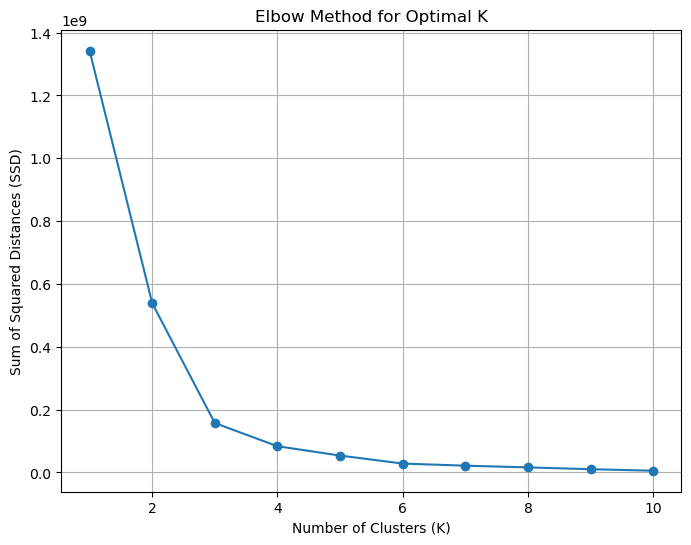

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")




# Initialize an empty list to store the SSD values
ssd_values = []

# Try different values of K (number of clusters)
K_range = range(1, 11)  # You can adjust the range as needed

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42, init='k-means++')
    kmeans.fit(Xs)
    ssd_values.append(kmeans.inertia_)  # Inertia is the SSD value

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, ssd_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances (SSD)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


In [24]:
optimal_k = 2

kmeans = KMeans(n_clusters= optimal_k, init= 'k-means++', random_state=42)

#fitting the kmeans to the data
kmeans.fit(Xs)

#assigning the clusters label to each customer in the data
customer_labels = kmeans.labels_

centroids = kmeans.cluster_centers_

# Add the cluster labels to your DataFrame if needed
RFM['Cluster'] = customer_labels


In [20]:
# kmeans = KMeans(n_clusters=2)

# RFM['Cluster'] = cluster 


In [25]:
RFM['Cluster'].value_counts()

0    239596
1     46259
Name: Cluster, dtype: int64

There are two cluster which have an even distribution

Calculate the Cluster Characteristics by comparing the different clusters on the following basis:

    * Number of customers
    * Sales contribution
    * Margin contribution
    * Monthly spend**
    * Shopping frequency

In [22]:
RFM.head()

,customer_id,Recency,Frequency,Monetary,Margin,customer_category,Cluster
0,1,40,3,0.113345,0.012630,0,0
1,40,45,1,0.130568,0.003280,2,0
2,52,177,2,0.016983,0.024028,2,1
3,91,-98,2,0.219541,0.024915,2,0
4,140,24,5,1.095341,0.481539,0,0


In [24]:
cluster_stats = RFM.groupby('Cluster').agg({
    'customer_id': 'count', #no of customers
    'Monetary': 'sum', #sales contribution
    'Margin': 'sum', #margin contribution
    'Frequency': 'mean' # shopping frequency
})

In [25]:
cluster_stats.head()

,customer_id,Monetary,Margin,Frequency
Cluster,,,,
0,239596,1002.12506,-169.598019,1.839893
1,46259,-1002.12506,169.598019,1.268856
